# Fake News Classifier using Logistic Regression with Naive Bayes features


This approach is inspired by the article [Baselines and Bigrams: Simple, Good Sentiment and Topic Classification](https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf) We will compute naive bayes features and use logistic regression on top of it

Notice that the decision function for naive Bayes can be rewritten as "predict class $0$ if the odds of $(0 \mid \mathbf {x} )$ exceed those of $(1\mid \mathbf {x} )$". Expressing this in log-space gives:

$$\log {\frac {p(0\mid \mathbf {x} )}{p(1 \mid \mathbf {x} )}}=\log p(0\mid \mathbf {x} )-\log p(1 \mid \mathbf {x} ) >0$$
We will multiply the (TF-IDF) feature matrix $X$ with the ratio above, called log count ratio, we will get a Naive Bayes adjusted TF-IDF Features. Intuitivey, initially, we had the TF features. Then, we multiplied them with the idf to put a larger weight to rare words. After that, we multiply these with the above ratio, that increase further the weights that matter most for the naive bayes classifier to make decisions. We will use a Logistic Regression classifier on these NB features.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_curve, auc

%matplotlib inline

In [2]:
dfInit = pd.read_csv('./data/fake_or_real_news.csv')

In [3]:
dfInit.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


quite unbalanced

In [4]:
labelDict = {'FAKE': 1, 'REAL':0}
dfInit['label'] = dfInit['label'].map(lambda s: labelDict[s])

In [5]:
data = dfInit[['text','label']]

In [6]:
data.head()

,text,label
0,"Daniel Greenfield, a Shillman Journalism Fello...",1
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,1
2,U.S. Secretary of State John F. Kerry said Mon...,0
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",1
4,It's primary day in New York and front-runners...,0


## Create TFIDF features, train-test split

In [8]:
tfidf = TfidfVectorizer(ngram_range=(1,2), 
               min_df=3, max_df=0.9, strip_accents='ascii', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )

In [9]:

Xtfidf = tfidf.fit_transform(data['text'])
y = data['label'].values

In [10]:
data.head()

,text,label
0,"Daniel Greenfield, a Shillman Journalism Fello...",1
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,1
2,U.S. Secretary of State John F. Kerry said Mon...,0
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",1
4,It's primary day in New York and front-runners...,0


In [11]:
Xtfidf_train, Xtfidf_test, ytfidf_train, ytfidf_test = train_test_split(Xtfidf, y, 
                                                            test_size=0.33, random_state=23)

##  Logistic Regression with Naive Bayes features

We will compute count vectors p1 = sum of all feature vectors with label 1 and p0 = sum of all feature vectors with label 0

In [12]:
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [13]:
x = Xtfidf_train

In [14]:
r = np.log(pr(1,ytfidf_train) / pr(0,ytfidf_train))
nblog = LogisticRegression(C=99, dual=True)
x_nb = x.multiply(r)
nblog.fit(x_nb, ytfidf_train)

LogisticRegression(C=99, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [15]:
y_nbtfidf_pred_train = nblog.predict(x_nb)
(y_nbtfidf_pred_train == ytfidf_train).sum() / len(ytfidf_train)

0.9988218661639963

In [16]:
y_nbtfidf_pred = nblog.predict(Xtfidf_test.multiply(r))
(y_nbtfidf_pred == ytfidf_test).sum() / len(ytfidf_test)

0.9507412721186035

## Evaluation

In [17]:

print('the f1 score using Logistic Regression with Naive Bayes features is %0.3f' 
      % f1_score(y_nbtfidf_pred,ytfidf_test))

the f1 score using Logistic Regression with Naive Bayes features is 0.953


In [18]:
fpr, tpr, threshold = roc_curve(ytfidf_test, y_nbtfidf_pred)
roc_auc = auc(fpr, tpr)

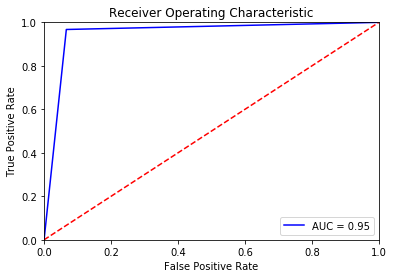

In [19]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()